In [1]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from csv_parser import CSVParser


In [2]:
#We have two resampled and therefore regular datasets, now we need to make our time series into a supervised problem.
#First I need to change navstat into a categorical feature:


# Define categories based on ranges or discrete values
total_df = pd.read_csv("../../resources/resampled_data_20min.csv")

# total_df = pd.read_csv("../../resources/resampled_data_h.csv")

total_df['etaParsed'] = pd.to_datetime(total_df['etaParsed'])
total_df["time"] = pd.to_datetime(total_df['time'])

start_date = pd.to_datetime('2024-01-01')

total_df["etaParsed"] = (total_df['etaParsed'] - start_date).dt.days


total_df = total_df.drop(columns=["navstat"])



time_diffs = total_df["time"].diff()
time_interval = time_diffs.dropna().iloc[0]
time_interval = int(time_interval.total_seconds()/(60*20))



total_df.set_index("time", inplace=True)




In [3]:
STEPSIZES = [1, 3, 6, 18, 36, 72, 144, 216, 288, 360]
OUTPUT_WINDOW = 1
INPUT_WINDOW = 4
OUTPUT_FORECAST = ["latitude", "longitude", "cog", "sog", "rot", "heading"]

In [4]:
#Make time series into supervised problem

# 1 = 20 minutes
# 3 = 1 hour
# 18 = 6 hours
# 72 = 24 hours
# 144 = 2 days
# 216 = 3 days
# 288 = 4 days
# 360 = 5 days



def make_supervised(df, forecast_columns, sorting_column, input_window=1, output_window=1, size=1):
    """
    Converts a multivariate time series dataframe into a supervised learning problem.
    
    Parameters:
    df (pd.DataFrame): The original dataframe with time series data.
    forecast_columns (list): A list of column names to forecast.
    input_window (int): The number of past observations to use as features.
    output_window (int): The number of steps to forecast into the future.
    
    Returns:
    pd.DataFrame: A new dataframe with supervised learning format.
    """
    df_nth=df.copy()
    
    if size > 1:
        df_nth = df_nth.iloc[::-size]
        df_nth = df_nth.iloc[::-1]

    df_holder = []
    
    #Put in a for loop here where you iterate over all IDs, to make sure things get correct
    unique_sorts = df_nth[sorting_column].unique()

    forbidden_cols = ["vesselId", "UN_LOCODE", "ISO", "portId", "etaParsed"]
    
    #Iterate through all IDs
    for sorts in unique_sorts:
        df_supervised = pd.DataFrame()
        sort_df = df_nth[df_nth[sorting_column] == sorts]

        #Iterate through all columns for input features
        for col in sort_df.columns: 
            if col in forbidden_cols:
                    continue
            for i in range(input_window, 0, -1):
                df_supervised[f"{col}_t-{i}"] = sort_df[col].shift(i)
            
            df_supervised[f"{col}_t"] = sort_df[col]
            

    # Create columns for forecast (target) with forward shift
        for col in forecast_columns:
            for j in range(output_window, 0,-1):
                df_supervised[f"{col}_t+{j}"] = sort_df[col].shift(-j)
        
        df_holder.append(df_supervised)
    

    
    df_new = pd.DataFrame()
    
    for chunk in df_holder:
        df_new = pd.concat([df_new, chunk])
    # Remove rows with NaN values caused by the shifting process
    df_new.dropna(inplace=True)

    return df_new

supervised_df = make_supervised(total_df, OUTPUT_FORECAST,"vesselId" , INPUT_WINDOW, OUTPUT_WINDOW)


In [5]:
#Sorting by time
supervised_df = supervised_df.sort_index(ascending = True)

#Sorting columns
def sort_columns(df):
    
    # Extract suffixes and assign _t as _t0
    columns_with_suffix = []
    for col in df.columns:
        match = re.search(r"_t([+-]?\d*)$", col)
        # If there's no number after _t, treat it as _t0
        suffix = int(match.group(1)) if match.group(1) else 0
        columns_with_suffix.append((col, suffix))
    
    # Sort by suffix value (ascending)
    sorted_t_columns = [col for col, _ in sorted(columns_with_suffix, key=lambda x: x[1])]
    
    # Reorder dataframe columns
    return df[sorted_t_columns]

supervised_df=sort_columns(supervised_df)


In [6]:


def train_test_split(df, perc1, perc2, output_window):
    y_list = []
    for j in range(output_window):
        for col in OUTPUT_FORECAST:
            y_list.append(f"{col}_t+{j+1}")
    ys = df[y_list]
    Xs = df.drop(columns = y_list)

    X_train = Xs.iloc[:int(np.round(Xs.shape[0]*perc1)),:]
    y_train = ys.iloc[:int(np.round(Xs.shape[0]*perc1)),:]
    X_val = Xs.iloc[int(np.round(Xs.shape[0]*perc1)):int(np.round(Xs.shape[0]*perc2)),:]
    y_val = ys.iloc[int(np.round(Xs.shape[0]*perc1)):int(np.round(Xs.shape[0]*perc2)),:]
    X_test = Xs.iloc[int(np.round(Xs.shape[0]*perc2)):,:]
    y_test = ys.iloc[int(np.round(Xs.shape[0]*perc2)):,:]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = train_test_split(supervised_df, 0.75, 0.85, OUTPUT_WINDOW)


In [7]:
model = xgb.XGBRFRegressor()

model.fit(X_train, y_train, verbose=True)
preds = model.predict(X_val)

In [8]:
def closest_20_min_mark(timestamp):
    timestamp = pd.to_datetime(timestamp)
    minutes = timestamp.minute
    closest_mark = round(minutes / 20) * 20
    if closest_mark == 60:
        rounded_timestamp = timestamp.replace(minute=0, second=0, microsecond=0) + pd.Timedelta(hours=1)
    else:
        rounded_timestamp = timestamp.replace(minute=closest_mark, second=0, microsecond=0)
    
    return rounded_timestamp

print(y_train.iloc[0])
print(X_val.iloc[0])
print(preds[0])

latitude_t+1    -35.16787
longitude_t+1   -56.77210
cog_t+1          92.80000
sog_t+1          14.20000
rot_t+1           0.00000
heading_t+1      90.00000
Name: 2024-01-01 01:20:00, dtype: float64
cog_t-4              227.80000
sog_t-4               15.70000
rot_t-4                0.00000
heading_t-4          229.00000
latitude_t-4          37.72620
longitude_t-4         24.27088
portLongitude_t-4     24.31700
portLatitude_t-4      37.65000
cog_t-3              227.80000
sog_t-3               15.70000
rot_t-3                0.00000
heading_t-3          229.00000
latitude_t-3          37.72620
longitude_t-3         24.27088
portLongitude_t-3     24.31700
portLatitude_t-3      37.65000
cog_t-2              227.80000
sog_t-2               15.70000
rot_t-2                0.00000
heading_t-2          229.00000
latitude_t-2          37.72620
longitude_t-2         24.27088
portLongitude_t-2     24.31700
portLatitude_t-2      37.65000
cog_t-1              227.80000
sog_t-1               15.70

In [9]:
def shift_to_back(process_df):
    
            
    for _, col in enumerate(OUTPUT_FORECAST):

        max_suffix_neg = 0
        max_suffix_pos = 0
        
        # Identify existing suffixes in the process_df for the current column
        while f"{col}_t-{max_suffix_neg+1}" in process_df.columns:
            max_suffix_neg += 1
        while f"{col}_t+{max_suffix_pos+1}" in process_df.columns:
            max_suffix_pos += 1
        for shift in range(max_suffix_neg - 1, -max_suffix_pos, -1):  # Start from max_suffix-1 down to 0
            if shift == 0:
                # Set the new predicted value as the most recent
                process_df[f"{col}_t"] = process_df[f"{col}_t+1"]
            elif shift == 1:
                # Shift the column
                process_df[f"{col}_t-{shift}"] = process_df[f"{col}_t"]
            elif shift > 1:
                # Shift the column
                process_df[f"{col}_t-{shift}"] = process_df[f"{col}_t-{shift - 1}"]
            else:
                process_df[f"{col}_t+{-shift}"] = process_df[f"{col}_t+{-shift + 1}"]

        for shift in range(1, max_suffix_pos+1):
            process_df = process_df.drop(columns=[f"{col}_t+{shift}"])
    
    return process_df


In [10]:
def predict_far_future(model, features, test_df,  forecast_columns):
    
    X_test = features.copy().iloc[-1:]
    preds = pd.DataFrame(columns=["vesselId", "approximate_time"])
    
    # Determine the furthest time in 20-minute intervals
    furthest_time = closest_20_min_mark(test_df["time"].max())
    current_time = closest_20_min_mark(X_test.index.max())
    
    # Generate the future time steps at 20-minute intervals
    future_steps = pd.date_range(start=current_time, end=furthest_time, freq='20min')
    
    for future_time in future_steps:
        y_pred = model.predict(X_test)

        new_row = pd.DataFrame({
            "vesselId": [test_df["vesselId"].iloc[0]],
            "approximate_time": [future_time]
        })
        for idx, col in enumerate(forecast_columns):
            new_row[f"{col}"] = y_pred[0, idx]  # Use the predicted value
        
        preds = pd.concat([preds, new_row], ignore_index=True)
        
        # Update X_test for the next iteration
        for idx, col in enumerate(forecast_columns):

            max_suffix = 0
            
            # Identify existing suffixes in the X_test for the current column
            while f"{col}_t-{max_suffix+1}" in X_test.columns:
                max_suffix += 1
            for shift in range(max_suffix - 1, -1, -1):  # Start from max_suffix-1 down to 0
                if shift == 0:
                    # Set the new predicted value as the most recent
                    X_test[f"{col}_t"] = y_pred[0, idx]
                elif shift == 1:
                    # Shift the column
                    X_test[f"{col}_t-{shift}"] = X_test[f"{col}_t"]
                else:
                    # Shift the column
                    X_test[f"{col}_t-{shift}"] = X_test[f"{col}_t-{shift - 1}"]
    
    return preds


csv_parser = CSVParser(folderpath="../../resources")

test_df = csv_parser.retrieve_test_data().iloc[:2]




In [ ]:
def predict_times(model,total_df,test_df):
    unique_sorts = test_df["vesselId"].unique()
    preds_df = pd.DataFrame()
    result = pd.DataFrame()

    for sorts in unique_sorts:
        latest_features=total_df[total_df["vesselId"] == sorts]
        test_by_vessel_df = test_df[test_df["vesselId"] == sorts]
        latest_features = make_supervised(latest_features, OUTPUT_FORECAST, "vesselId" , INPUT_WINDOW, OUTPUT_WINDOW)
        latest_features = shift_to_back(latest_features)
        latest_features = sort_columns(latest_features)
        preds = predict_far_future(model, latest_features, test_by_vessel_df, OUTPUT_FORECAST)
        preds_df = pd.concat([preds_df, preds])
    
    for test in test_df.iterrows():
        test=pd.Series(test[1])
        print(test["ID"])
        new_row = pd.DataFrame()
        new_row=preds_df[
            (preds_df["vesselId"] == test["vesselId"]) & 
            (preds_df["approximate_time"] == closest_20_min_mark(test["time"]))
            ][["latitude", "longitude"]]
        new_row["ID"] = test["ID"]
        new_row["time"] = test["time"]
        
        result = pd.concat([result, new_row])
    result["latitude_predicted"] = result["latitude"]
    result["longitude_predicted"] = result["longitude"]
    return result["ID","longitude_predicted","latitude_predicted"]

print(test_df)
result_df = predict_times(model, total_df, test_df)
print(result_df)





   ID                  vesselId                time  scaling_factor
0   0  61e9f3aeb937134a3c4bfe3d 2024-05-08 00:03:16             0.3
1   1  61e9f473b937134a3c4c02df 2024-05-08 00:06:17             0.3


C:\Users\Bruker\AppData\Local\Temp\ipykernel_26324\2334808892.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  preds = pd.concat([preds, new_row], ignore_index=True)
C:\Users\Bruker\AppData\Local\Temp\ipykernel_26324\2334808892.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  preds = pd.concat([preds, new_row], ignore_index=True)


0
1


KeyError: ('ID', 'longitude_predicted', 'latitude_predicted')

In [12]:
results = {
    "MAE": mean_absolute_error(y_val, preds),
    "MSE": np.square(np.subtract(y_val,preds)).mean(),
    "R2 Score": r2_score(y_val, preds),
    "RMSE": np.sqrt(np.square(np.subtract(y_val,preds)).mean())
}

for metric, value in results.items():
    print(f"{metric}: {value}")

MAE: 3.3883701844688487
MSE: latitude_t+1        0.802386
longitude_t+1       8.475985
cog_t+1          1212.307455
sog_t+1             1.112950
rot_t+1            73.708548
heading_t+1       616.228982
dtype: float64
R2 Score: 0.9358322919508523
RMSE: latitude_t+1      0.895760
longitude_t+1     2.911355
cog_t+1          34.818206
sog_t+1           1.054965
rot_t+1           8.585368
heading_t+1      24.823960
dtype: float64


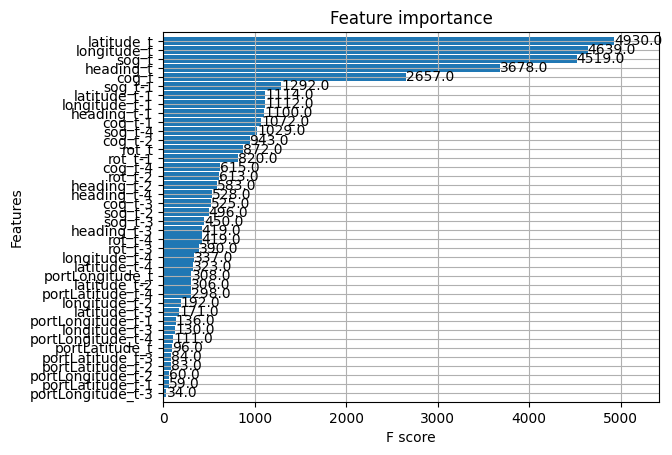

In [13]:
_ = plot_importance(model, height=0.9)

### First model:
Included navstat and etaParsed

Timewindow: (3,2)

MAE: 0.8521843262281953 

MSE: longitude_t+1    21.225563

latitude_t+1      1.993130

longitude_t+2    38.471488

latitude_t+2      3.840146

dtype: float64

R2 Score: 0.9958523607729776

RMSE: longitude_t+1    4.607121

latitude_t+1     1.411783

longitude_t+2    6.202539

latitude_t+2     1.959629

dtype: float64


### Second model:

Added cog, rot and heading to target features.

Timewindow: (3,2)

MAE: 7.198335594601071
MSE: latitude_t+1        1.980426
longitude_t+1      21.577318
cog_t+1          1820.208937
rot_t+1            92.532501
heading_t+1      1172.604934
latitude_t+2        3.813640
longitude_t+2      39.218475
cog_t+2          2370.325440
rot_t+2           107.991661
heading_t+2      1769.347459
dtype: float64
R2 Score: 0.8826565909012996
RMSE: latitude_t+1      1.407276
longitude_t+1     4.645139
cog_t+1          42.663907
rot_t+1           9.619382
heading_t+1      34.243320
latitude_t+2      1.952854
longitude_t+2     6.262466
cog_t+2          48.685988
rot_t+2          10.391904
heading_t+2      42.063612
dtype: float64
